In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import jupyter_black

# jupyter_black.load(is_lab=True)

import os
from operator import itemgetter

%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

In [2]:
import warnings


def fxn():
    warnings.warn("deprecated", DeprecationWarning)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

<IPython.core.display.Javascript object>

In [3]:
from nltk.corpus import stopwords
import re

from termcolor import colored
import math

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

import gensim

nltk.download("wordnet")
nltk.download("omw-1.4")
from nltk import word_tokenize


import math
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from gensim.models.ldamodel import LdaModel

[nltk_data] Downloading package wordnet to /home/angelo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/angelo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<IPython.core.display.Javascript object>

In [4]:
os.chdir(
    "/home/angelo/Documents/Uni/Courses/Digital Transformation & Supply Chain/supply_chain_assignment/"
)

<IPython.core.display.Javascript object>

# Part 1

## Data Preparation

In [5]:
df_customer_Churn = pd.read_csv("Data/Daily_Churned_customers_JET.csv")

df_input_accounts = pd.read_csv("Data/input_accounts_21_10_2022.csv")

df_tweets = pd.read_csv("Data/tweets-2022-10-21_justeattakeaway.csv")

<IPython.core.display.Javascript object>

In [6]:
df_tweets = pd.merge(
    left=df_tweets,
    right=df_input_accounts,
    left_on="user_id",
    right_on="user_id",
    how="left",
)
df_input_accounts = None

<IPython.core.display.Javascript object>

In [7]:
# add a simple dummy for JET companies or not
df_tweets["JET"] = 0
df_tweets.loc[
    df_tweets.full_name.isin(["thuisbezorgd", "Just Eat Takeaway.com", "Just Eat UK"]),
    "JET",
] = 1

# remove all non english tweets
df_tweets = df_tweets[df_tweets.lang == "en"]

<IPython.core.display.Javascript object>

In [8]:
# delta chrun
df_customer_Churn["d_churn"] = (
    df_customer_Churn["Churned customers"].shift(1)
    - df_customer_Churn["Churned customers"]
)

<IPython.core.display.Javascript object>

# Part 2

## Lanugage Preprocessing 

In [9]:
additional = [
    "rt",
    "rts",
    "retweet",
    "please",
    "ha",
    "w",
    "dm",
]  # we'll store additional stopwords here
swords = set().union(stopwords.words("english"), additional)

# replace all signs and stopwords in tweets and tokenize tweets (tokenization means splitting up a larger body of text into pieces such as words, keywords, phrases, symbols and other elements called tokens; in our case we can split the tweets into words)
df_tweets.drop_duplicates(subset="text", inplace=True)
df_tweets["text"] = df_tweets["text"].str.lower()

df_tweets["processed_text"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
    .apply(lambda x: [i for i in x.split() if not i in swords])
)

df_tweets["simple_preprocessing"] = (
    df_tweets["text"]
    .str.lower()
    .str.replace("(@[a-z0-9]+)\w+", " ")
    .str.replace("(http\S+)", " ")
    .str.replace("([^0-9a-z \t])", " ")
    .str.replace(" +", " ")
)

/tmp/ipykernel_78221/1352246052.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets["text"]
/tmp/ipykernel_78221/1352246052.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  df_tweets["text"]


<IPython.core.display.Javascript object>

In [10]:
wnl = WordNetLemmatizer()


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        regex_num_ponctuation = "(\d+)|([^\w\s])"
        regex_little_words = r"(\b\w{1,2}\b)"
        regex_smiley = "(@[a-z0-9]+)\w+"
        regex_signs = "(http\S+)"
        regex_tweet_spec = "([^0-9a-z \t])"
        regex_https = " +"
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if not re.search(regex_num_ponctuation, t)
            and not re.search(regex_smiley, t)
            and not re.search(regex_signs, t)
            and not re.search(regex_tweet_spec, t)
            and not re.search(regex_little_words, t)
            and not re.search(regex_https, t)
        ]

<IPython.core.display.Javascript object>

In [11]:
swords = set().union(stopwords.words("english"), additional)

count = CountVectorizer(
    stop_words=swords,
    tokenizer=LemmaTokenizer(),
    ngram_range=(1, 2),  # will create a vocabulary with 1-gram and 2-grams
    min_df=3,
    max_df=0.8,
    max_features=2000,
    lowercase=True,
    strip_accents="unicode",
)

matrix = count.fit_transform(df_tweets.simple_preprocessing)


results = pd.DataFrame(matrix.toarray(), columns=count.get_feature_names())
results

/home/angelo/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'doe', 'might', 'must', 'need', 'sha', 'wa', 'would'] not in stop_words.
  warnings.warn(
/home/angelo/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,able,able drop,able follow,able get,able look,able place,able resolve,able send,absolutely,accordingly,...,year,yes,yesterday,yesterday sorry,yet,yet account,yet order,yet resolved,young,young people
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14755,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [12]:
corpus = gensim.matutils.Sparse2Corpus(matrix, documents_columns=False)
id_map = dict((v, k) for k, v in count.vocabulary_.items())


K = 12
lda = LdaModel(
    corpus=corpus,
    id2word=id_map,
    num_topics=K,
    alpha="auto",
    eta="auto",
    iterations=100,
    passes=20,
    eval_every=None,
    random_state=42,
    per_word_topics=True,
)

In [ ]:
# lda.print_topics()

[(0,
  '0.054*"read" + 0.032*"email" + 0.030*"mind" + 0.029*"order" + 0.029*"sorry" + 0.028*"address" + 0.028*"yet" + 0.027*"detail" + 0.027*"account" + 0.026*"email address"'),
 (1,
  '0.079*"closer look" + 0.076*"take closer" + 0.033*"email" + 0.033*"message" + 0.032*"send" + 0.031*"address" + 0.028*"information" + 0.028*"email address" + 0.026*"account" + 0.024*"number"'),
 (2,
  '0.025*"via" + 0.024*"eat" + 0.018*"takeaway" + 0.018*"across" + 0.017*"number via" + 0.016*"restaurant" + 0.016*"thing" + 0.016*"food" + 0.015*"disappointed" + 0.013*"definitely"'),
 (3,
  '0.052*"assist" + 0.049*"happy" + 0.048*"support" + 0.045*"help" + 0.042*"happy help" + 0.027*"uber" + 0.026*"eats" + 0.025*"team" + 0.025*"uber eats" + 0.025*"mobile"'),
 (4,
  '0.045*"dm" + 0.036*"get" + 0.033*"thank reaching" + 0.032*"member" + 0.029*"back" + 0.028*"member team" + 0.025*"help" + 0.025*"attention" + 0.025*"app" + 0.024*"twitter"'),
 (5,
  '0.041*"customer" + 0.019*"security" + 0.016*"delivery" + 0.016*

<IPython.core.display.Javascript object>

In [ ]:
by_get_document_topics = list(map(lda.get_document_topics, corpus))

# extract topic loadings and topics by document
topic_loadings = {}
topic_number = {}
iter_ = 0
for loading in by_get_document_topics:
    t = list(map(itemgetter(1), loading))
    topic_loadings[iter_] = max(t)
    topic_number[iter_] = t.index(max(t))

<IPython.core.display.Javascript object>

In [ ]:
names = [
    "Rugby",
    "Video Games",
    "Radio",
    "Internet",
    "Politics",
    "Cybersecurity",
    "taas",
    "rtest",
    "rtest",
    "rtest",
]

topic_names = {i: v for i, v in enumerate(names)}

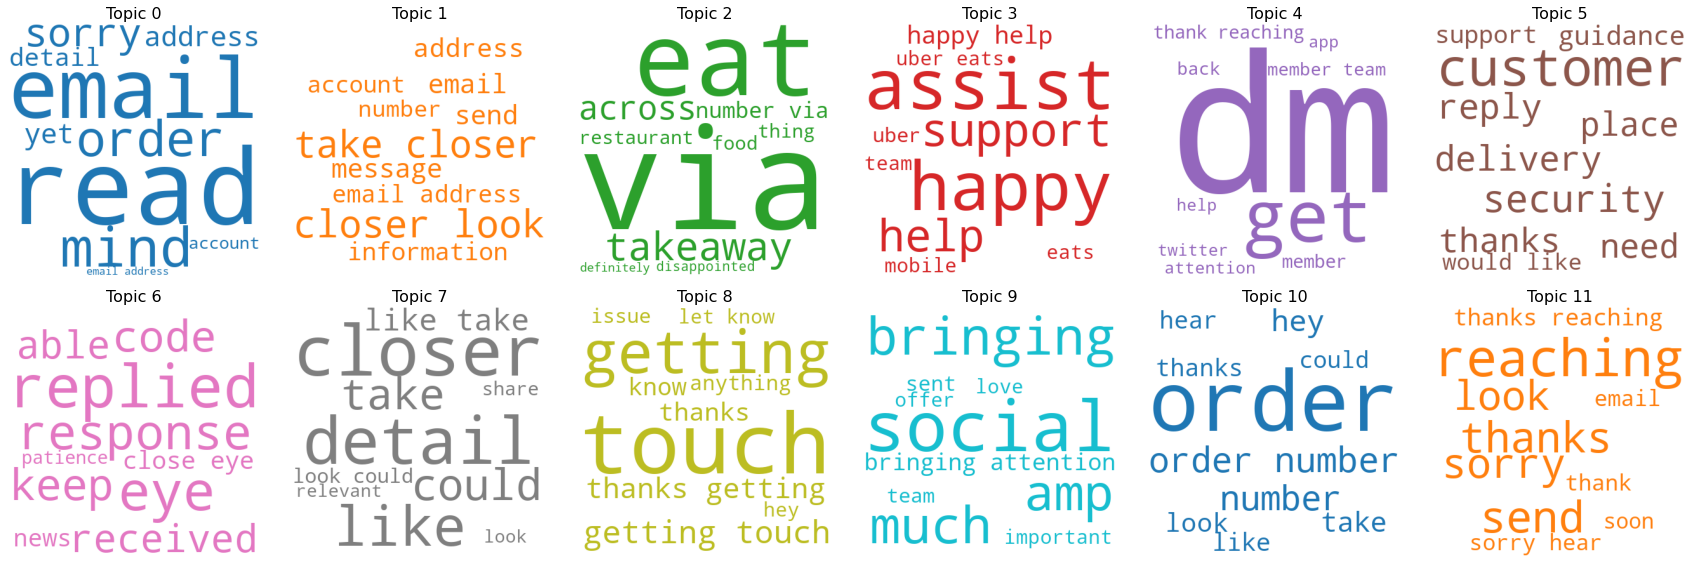

<IPython.core.display.Javascript object>

In [ ]:
nb_columns = 6
nb_rows = math.ceil(K / nb_columns)

cols = [
    color for name, color in mcolors.TABLEAU_COLORS.items()
]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * math.ceil(K / len(cols))

cloud = WordCloud(
    background_color="white",
    width=400,
    height=400,
    max_words=15,
    color_func=lambda *args, **kwargs: cols[i],
    prefer_horizontal=1.0,
)

topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)

fig, axes = plt.subplots(
    ncols=nb_columns,
    nrows=nb_rows,
    figsize=(4 * nb_columns, 4 * nb_rows),
    sharex=True,
    sharey=True,
)

for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    ax.imshow(cloud)
    ax.set_title("Topic " + str(i), fontdict=dict(size=16))
    ax.axis("off")


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis("off")
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


# nb_columns = 6
# nb_rows = math.ceil(K / nb_columns)

# cols = [
#     color for name, color in mcolors.TABLEAU_COLORS.items()
# ]  # more colors: 'mcolors.XKCD_COLORS'
# cols = cols * math.ceil(K / len(cols))

# cloud = WordCloud(
#     background_color="white",
#     width=400,
#     height=400,
#     max_words=15,
#     color_func=lambda *args, **kwargs: cols[i],
#     prefer_horizontal=1.0,
# )

# topics = lda.show_topics(num_topics=K, num_words=10, formatted=False)


# fig, axes = plt.subplots(
#     ncols=nb_columns,
#     nrows=nb_rows,
#     figsize=(4 * nb_columns, 4 * nb_rows),
#     sharex=True,
#     sharey=True,
# )

# for i, (topic, ax) in enumerate(zip(topics, axes.flatten())):
#     topic_words = dict(topic[1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)
#     ax.imshow(cloud)
#     ax.set_title("Topic " + str(names[i]), fontdict=dict(size=16))
#     ax.axis("off")


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis("off")
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

# Part 3

# Part 4

# Part 5